# LN Model to predict responses of simulated RGCs to natural images

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler

In [2]:
from lurz2020.datasets.mouse_loaders import static_loaders
from lurz2020.utility.measures import *
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import numpy as np
from scipy import linalg
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from theonerig.modelling import *
from datetime import datetime

In [3]:
# Load train, test and validation dataset images

path_images = ['D://inception_loop/RGC_sim_data/data/static27012021_original_images']

dataset_config = {'paths': path_images, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True,
                 'exclude': "images"}

dataloaders_images = static_loaders(**dataset_config)
dat = FileTreeDataset('D://inception_loop/RGC_sim_data/data/static27012021_original_images', "images", "responses")
dataset_name = '27012021_original_images'

tier_train = 'train'
images_train_set = [] 
responses_train_set = []
for x, y in dataloaders_images[tier_train][dataset_name]:
    images_train_set.append(x.squeeze().cpu().data.numpy())
    responses_train_set.append(y.squeeze().cpu().data.numpy())
    
images_train_set = np.vstack(images_train_set)
responses_train_set = np.vstack(responses_train_set)

tier_validation = 'validation'
images_validation_set = []
responses_validation_set = []
for x, y in dataloaders_images[tier_validation][dataset_name]:
    images_validation_set.append(x.squeeze().cpu().data.numpy())
    responses_validation_set.append(y.squeeze().cpu().data.numpy())
    
images_validation_set = np.vstack(images_validation_set)
responses_validation_set = np.vstack(responses_validation_set)

tier_test = 'test'
images_test_set = []
responses_test_set = []
for x, y in dataloaders_images[tier_test][dataset_name]:
    images_test_set.append(x.squeeze().cpu().data.numpy())
    responses_test_set.append(y.squeeze().cpu().data.numpy())
    
images_test_set = np.vstack(images_test_set)
responses_test_set = np.vstack(responses_test_set)

oracle_dataloader_LN = static_loaders(**dataset_config, return_test_sampler=True, tier='test')

Returning only test sampler with repeats...


In [15]:
# Define functions for the estimation of parameters and linear RF with decorr STA

def STA_estim(neuron, responses_training_set, images_training_set, rcond, c, b):
    
    S = []
    for i in range(len(images_training_set)):
        image = images_training_set[i].ravel()
        image_std = (image-np.min(image))/(np.max(image)-np.min(image))
        image_scaled = (image_std*2)-1
        S.append(image_scaled)
    S = np.array(S)
    
    sta_neuron = []
    sta_neuron_decorr = []
    
    pseudo_inv = linalg.pinv2(S, rcond)
    sta = np.dot(pseudo_inv, responses_training_set[:,neuron])
    sta_neuron_decorr = (sta/sum(responses_training_set[:,neuron])).reshape(images_training_set.shape[1],images_training_set.shape[2])
    #sta_neuron = (np.dot(S.T, responses_training_set[:,neuron])/sum(responses_training_set[:,neuron])).reshape(images_training_set.shape[1],images_training_set.shape[2])
    
    sta_neuron_decorr = (sta_neuron_decorr * c) + b
     
    return sta_neuron_decorr

def ELU(r):
    
    if r>0:
        nonlin_response = r + 1
    else:
        nonlin_response = np.exp(r) + 1
    return nonlin_response

def pred_RGC_response(rf, images):
    spikes = []
    for image in images:
        image_std = (image-np.mean(image))
        image_scaled = (image_std*2)-1
        Img_barHat = image_scaled * rf
        g = ELU(np.sum(Img_barHat.ravel()))
        spikes.append(np.random.poisson(lam=g, size=None))
        
    return spikes

def pred_RGC_response_on_RF(rf, images):
    spikes = []
    for image in images:
        image_std = (image-np.mean(image))
        image = (image_std*2)-1
        fit_dict = fit_spatial_sta(rf)[0]
        rf_center_x, rf_center_y = fit_dict['x0_1'], fit_dict['z0_1']
        f=lambda a: int((abs(a)+ a)/2)
        window_rf = 10
        Img_barHat = image[f(rf_center_y-window_rf):f(rf_center_y+window_rf), f(rf_center_x-window_rf):f(rf_center_x+window_rf)] * rf[f(rf_center_y-window_rf):f(rf_center_y+window_rf), f(rf_center_x-window_rf):f(rf_center_x+window_rf)]
        g = ELU(np.sum(Img_barHat.ravel()))
        spikes.append(np.random.poisson(lam=g, size=None))
        
    return spikes

def predicted_LN_responses(neurons, rfs, images_test_set, responses_test_set=None, return_corr=False):
    responses_pred = []
    corr_true_pred = []
    for x in range(len(neurons)):
        y_pred = pred_RGC_response(rfs[x], images_test_set)
        responses_pred.append(y_pred)
        if return_corr:
            y_true = responses_test_set[:,neurons[x]]
            corr_true_pred.append(pearsonr(y_true, y_pred)[0])
        if (x % 500) == 0:
            print(x)
            
    if return_corr:
        return np.vstack(x for x in corr_true_pred)
    else:
        return np.array(responses_pred).T

def model_predictions_repeats_LN(neurons, rfs, dataloader, broadcast_to_target=True):
    """
    Computes model predictions for a dataloader that yields batches with identical inputs along the first dimension.
    Unique inputs will be forwarded only once through the model
    """
    target = []
    unique_images = []
    for images, responses in dataloader:
        if len(images.shape) == 5:
            images = images.squeeze(dim=0)
            responses = responses.squeeze(dim=0)

        assert torch.all(torch.eq(images[-1,], images[0,])), "All images in the batch should be equal"
        unique_images.append(images[0:1,].squeeze().cpu().data.numpy())
        target.append(responses.detach().cpu().numpy())

    # Forward unique images once:
    output = predicted_LN_responses(neurons=neurons, rfs=rfs, images_test_set=unique_images, return_corr=False)
    output_norm = output/np.std(output)

    if broadcast_to_target:
        output = [np.broadcast_to(x, target[idx].shape) for idx, x in enumerate(output_norm)]

    return target, output

def compute_FEV(neurons, rfs, oracle_dataloader):
    """
    Computes the fraction of explainable variance explained (FEVe) per Neuron, given a model and a dictionary of dataloaders.
    The dataloaders will have to return batches of identical images, with the corresponing neuronal responses.
    """
    dataloaders = oracle_dataloader["test"][dataset_name] if "test" in oracle_dataloader else oracle_dataloader[dataset_name]
    
    targets, outputs = model_predictions_repeats_LN(neurons, rfs, dataloader = dataloaders, broadcast_to_target=True)
    
    ImgVariance = []
    PredVariance = []
    for i, _ in enumerate(targets):
        PredVariance.append((targets[i] - outputs[i]) ** 2)
        ImgVariance.append(np.var(targets[i], axis=0, ddof=1))
    PredVariance = np.vstack(PredVariance)
    ImgVariance = np.vstack(ImgVariance)

    TotalVar = np.var(np.vstack(targets), axis=0, ddof=1)
    NoiseVar = np.mean(ImgVariance, axis=0)
    FEV = (TotalVar - NoiseVar) / TotalVar

    PredVar = np.mean(PredVariance, axis=0)
    FEVe = 1 - (PredVar - NoiseVar) / (TotalVar - NoiseVar)
    
    FEV = np.mean(np.hstack([v for v in FEVe]))
    return FEV

def compute_FOR(neurons, rfs, images_test_set, responses_test_set, oracle_dataloader):
    dataloaders = oracle_dataloader["test"] if "test" in oracle_dataloader else oracle_dataloader
    
    oracles = get_oracles(dataloaders=dataloaders, as_dict=False, per_neuron=True)
    test_correlation = predicted_LN_responses(neurons, rfs, images_test_set, responses_test_set, return_corr=True)

    oracle_performance, _, _, _ = np.linalg.lstsq(np.hstack(oracles)[:, np.newaxis], np.hstack(test_correlation))
    return oracle_performance

def LN_estim_grid(rcond, c, b):
    rfs  = []
    for neuron in neurons:
        rfs.append(STA_estim(neuron, responses_train_set, images_train_set, rcond, c, b))
    predictions = predicted_LN_responses(neurons, rfs, images_validation_set, responses_test_set=None, return_corr=False)
    gt = responses_validation_set[:,neurons]
    predicitons_norm = predictions/np.std(predictions)
    target = r2_score(gt, predicitons_norm)
    
    return target

-----------

## Optimization of LN model parameters with bayesian grid search

In [4]:
import random
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

# Select neurons for optimization with bayesian grid search
#neurons = random.sample(range(len(responses_train_set[0,:])), 500)
neurons = range(500)

In [ ]:
#Probe rcond values to determine bounds for bayesian grid search
neuron = 560
rfs, rfs_decorr = STA_estim(neuron, responses_train_set, images_train_set)
y_pred = np.array(pred_RGC_response(rfs_decorr, images_test_set))
plt.imshow(rfs)

In [7]:
%%time 
%%memit
#Optimization to maximize the target (corresponding to the correlation between the LN model predictions and the real responses for the validation set)

# Bounded region of parameter space
pbounds = {'rcond': (1,100), 'c': (100,8000), 'b': (0.005, 0.1)} #Fill in with pre-determined bounds
pbounds_2 = {'rcond': (10,50), 'c': (1000,8000), 'b': (0.0005, 0.5)} #Fill in with pre-determined bounds after first search

optimizer_LN = BayesianOptimization(
    f=LN_estim_grid,
    pbounds=pbounds_2,
    random_state=1,
    verbose = 1,
)

#Load previously seen points
load_logs(optimizer_LN, logs= [r"D:\inception_loop\RGC_sim_data\results\grid_search_LN_model_logs_var.json"]);

#Set location to save progress and results
#logger = JSONLogger(path=r"D:\inception_loop\RGC_sim_data\results\2nd_grid_search_LN_model_logs_var.json")
#optimizer_LN.subscribe(Events.OPTIMIZATION_STEP, logger)

#Run grid search
#init_points: number of random exploration points
#n_iter: number of exploitation points

#optimizer_LN.maximize(init_points=5, n_iter=5)

peak memory: 1423.48 MiB, increment: 0.01 MiB
Wall time: 2.36 s


In [8]:
# Best parameters combination for dataset
optimizer_LN.max

{'target': 0.22796590208431466,
 'params': {'b': 0.010456680106848457,
  'c': 2820.2590423607735,
  'rcond': 29.68474176015265}}

In [16]:
# All values probed during grid search
optimizer_LN.res

[{'target': -0.40595516479806576,
  'params': {'b': 0.20880249134893572,
   'c': 3440.6489868843164,
   'rcond': 10.004574992693795}},
 {'target': -0.4560469603822521,
  'params': {'b': 0.15151512002960396,
   'c': 2293.5117816342263,
   'rcond': 13.693543790751912}},
 {'target': 0.003718344801061093,
  'params': {'b': 0.09353697558314662,
   'c': 2691.1214540860956,
   'rcond': 25.870698969226797}},
 {'target': -1.0607086131869132,
  'params': {'b': 0.2696389586346768,
   'c': 2838.3890288065895,
   'rcond': 37.40878001587038}},
 {'target': 0.06694379023253645,
  'params': {'b': 0.10262389874089296,
   'c': 3756.2348727818908,
   'rcond': 11.095503727917047}},
 {'target': -0.9316445682570411,
  'params': {'b': 0.3714167846318081,
   'c': 3754.975915976811,
   'rcond': 12.801825094875024}},
 {'target': -0.5965762516924015,
  'params': {'b': 0.26638281119854995,
   'c': 3574.768017605836,
   'rcond': 16.995990991229917}},
 {'target': -1.2807947218675635,
  'params': {'b': 0.298124300308

In [12]:
# Prepare grid search result data for plotting 
b = []
c = []
rcond = []
target = []
for i in range(len(optimizer_LN.res)):
    target.append(optimizer_LN.res[i]['target'])
    b.append(optimizer_LN.res[i]['params']['b'])
    c.append(optimizer_LN.res[i]['params']['c'])
    rcond.append(optimizer_LN.res[i]['params']['rcond'])
    
dict_plot = {'b': b,
            'c': c,
            'rcond': rcond,
            'target':  target}

In [13]:
# Plot evolution of bayesian grid search
import pandas as pd
import plotly.express as px

df_gs_results = pd.DataFrame(data=dict_plot)

fig = px.parallel_coordinates(df_gs_results, color='target', color_continuous_scale = 'portland', title= f"Bayes Parameters Grid Search - LN model n={len(optimizer_LN.res)}")
fig.show()

-------------

## Evaluation of LN model performance 

In [12]:
# Estimate model filters/rfs for neurons using training dataset and selected parameters of the model
neurons = range(len(responses_train_set[0,:]))
rcond = 29.68 #19.3
c = 2820.25 #6467.29
b = 0.01  #0.062

rfs  = []
for neuron in neurons:
    rfs.append(STA_estim(neuron, responses_train_set, images_train_set, rcond, c, b))
    
np.save(r"D:\inception_loop\RGC_sim_data\results\stas_CS_RGC_LN_model.npy", rfs)

In [19]:
%%time

FEV_performance = compute_FEV(neurons, rfs, oracle_dataloader_LN)
FOR_performance = compute_FOR(neurons, rfs, images_test_set, responses_test_set, oracle_dataloader_LN)

print('FEV= '+str(FEV_performance)+'\n FOR= '+str(FOR_performance))

0
500
1000
1500
2000
0
500
1000
1500
2000
FEV= 0.16799815500395102
 FOR= [0.91650417]
Wall time: 1min 14s


<ipython-input-15-5f9b9c5a7af6>:72: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(x for x in corr_true_pred)
<ipython-input-15-5f9b9c5a7af6>:134: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  oracle_performance, _, _, _ = np.linalg.lstsq(np.hstack(oracles)[:, np.newaxis], np.hstack(test_correlation))


In [25]:
# Save performance results

with open("D://inception_loop/RGC_sim_data/results/performance_log_LN_model_CS.txt", "a") as log_file:
    comment = "LN model for simulated RGCs with CS RFs.\nParameters estimated for validation dataset with bayesian grid search, filters/stas estimated with train dataset and final performance computed for test dataset."
    date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    stim = "Stimuli dataset: " + dataset_name
    model_config = "Model parameters: \n rcodn=" + str(rcond)+"\n c="+str(c)+"\n b="+str(b)
    log_file.write(comment+'\n'+date+'\n'+ stim+'\n'+model_config+'\n')

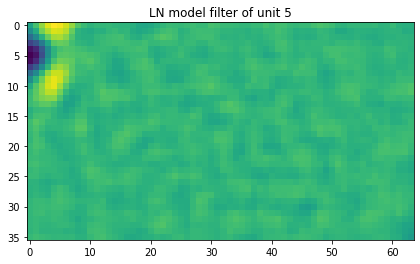

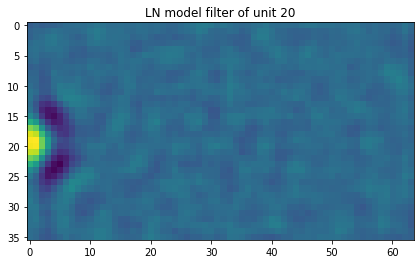

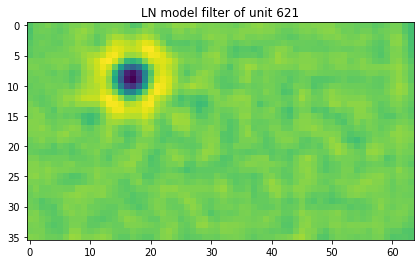

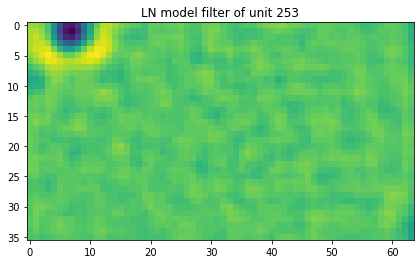

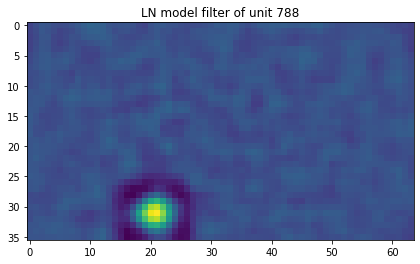

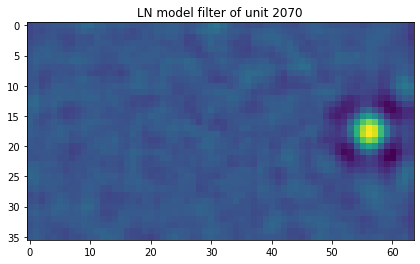

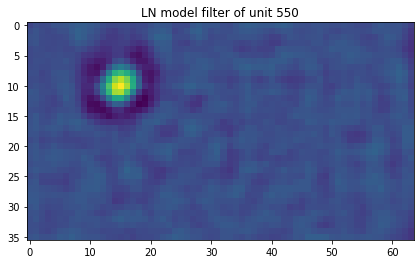

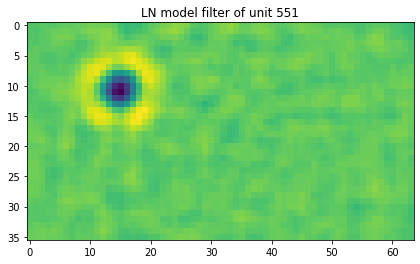

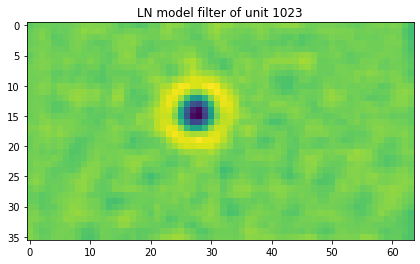

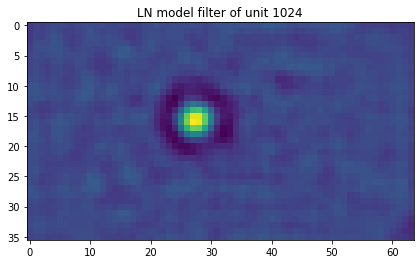

In [27]:
# Plot filters estimated with STA for specific list of target neurons
targets_list = [5,20,621,253,788,2070,550,551,1023,1024]

for TargetUnit in targets_list:
    fig, axs = plt.subplots(figsize=(7,4))
    axs.imshow(rfs[TargetUnit])
    axs.set_title('LN model filter of unit '+str(TargetUnit))

    plt.savefig('D://inception_loop/RGC_sim_data/results/LN_model_unit_'+str(TargetUnit)+'_CS_RGC.png')
    plt.close